# Питон и машинное обучение

# Модуль 9. Обучение без учителя

- Кластеризация
    - Алгоритм K-Means
    - Алгоритм DBSCAN
    - Метрики в задаче кластеризации
- Уменьшение размерности данных:
    - метод главных компонент (PCA)
    - t-SNE
- Классификация в рамках одного класса или поиск статистических выбросов 
- Классификация объектов по бесконечному количеству классов методом поиска ближайших соседей


Для чего используется кластеризация? Кластеризация - это элемент майнинга данных, который позволяет нам получать дополнительные категориальные признаки по принципу принадлежности объекта к тому или иному кластеру.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

matplotlib.rcParams['figure.figsize'] = (14,9)

%matplotlib inline

## Алгоритм K-means

Алгоритм K-means — это метод кластеризации, который группирует данные на основе их близости к центрам кластеров (центроидам). Вот краткое описание его работы:

1. __Инициализация__: Выбираются $K$ начальных центроидов случайным образом или с помощью метода, такого как ```k-means++```.
2. __Присваивание кластеров__: Каждая точка данных присваивается к ближайшему центроиду.
3. __Пересчет центроидов__: Вычисляется новое положение каждого центроида как среднее всех точек, присвоенных его кластеру.
4. __Итерация__: Шаги 2 и 3 повторяются, пока центроиды не перестанут существенно перемещаться, достигнуто максимальное количество итераций, или достигнута минимальная сумма внутрикластерных расстояний.

Алгоритм эффективен и легок в реализации, но требует предварительного знания количества кластеров $K$ и может быть чувствителен к начальной инициализации центроидов.

Посмотрим на работу алгоритма для случайно сгенерированных данных:

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs( n_samples=500, n_features=2, 
                  centers=4, 
                  cluster_std=0.7, 
                  shuffle=True, 
                  random_state=20240405)

plt.scatter(X[:,0], X[:,1], marker='o')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 4

km = KMeans(n_clusters=4, 
            init='random', 
            n_init=10, 
            max_iter=100, 
            tol=1e-4, random_state=0)
y_km = km.fit_predict(X)

Какую информацию мы можем получить из обученной модели?

In [ ]:
# метки принадлежности к обнаруженным кластерам
print(y_km)
print(km.cluster_centers_)

In [ ]:
# визуализируем это
fig, ax = plt.subplots()
for lbl, color in zip(np.unique(y_km), ['orange', 'green', 'blue', 'magenta']):
    idx = y_km == lbl
    ax.scatter(X[idx,0], X[idx,1], color=color, marker='o', label=lbl)
    
# центроиды
ax.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], marker='*', s=400, color='white', edgecolor='black')
    
ax.legend()
    
plt.show()

Зная центроиды кластеров, можно простроить диаграммы Вороного и граф триангуляции Делоне:

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import Delaunay, delaunay_plot_2d 

dln = Delaunay(km.cluster_centers_)
vor = Voronoi(km.cluster_centers_)

ax = plt.subplot(111)

# диаграмма Вороного
fig = voronoi_plot_2d( vor, ax=ax, show_points=True, line_width=3, line_alpha=0.6 )
# триангуляция Делоне
fig = delaunay_plot_2d( dln, ax=ax )

for lbl, color in zip(np.unique(y_km), ['orange', 'green', 'blue', 'magenta']):
    idx = y_km == lbl
    ax.scatter(X[idx,0], X[idx,1], color=color, marker='o')
    
# центроиды
ax.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], marker='*', s=400, color='white', edgecolor='black')

plt.show()

Данные из диаграмм Вороного могут быть использованы для оценки принадлежности к тому или иному кластеру вместо других методов (например, kNN).


Посмотрим, как заданное количество кластеров в k-means влияет на разбиение выборки:

In [ ]:
from ipywidgets import interact

def plot_kmeans(K):
    
    global km
    
    km = KMeans(n_clusters=K, 
            init='k-means++', n_init=10, max_iter=100, tol=1e-4, random_state=0)
    y_km = km.fit_predict(X)

    ax = plt.subplot(111)
    
    if K>2:
        # диаграмма Вороного
        vor = Voronoi(km.cluster_centers_)
        fig = voronoi_plot_2d( vor, ax=ax, show_points=True, line_width=3, line_alpha=0.6 )
    
    # точки
    for lbl, color in zip(np.unique(y_km), ['orange', 'green', 'blue', 'magenta', 'yellow', 'red']):
        idx = y_km == lbl
        ax.scatter(X[idx,0], X[idx,1], color=color, marker='o')

    # центроиды
    ax.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], marker='*', s=400, color='white', edgecolor='black')

interact(plot_kmeans, K=(2, 6));

Мера качества работы алгоритма k-means - ```inertia_```, она является суммой квадратов евклидовых расстояний от всех точек до центроида кластера.

Чем меньше значение этого показателя - тем лучше сгруппированы кластеры. 

In [ ]:
km.inertia_

При сомнении в выборе количества кластеров $K$ визуализируют затухание этой меры и берут то значение, когда затухание становится незначительным:

In [ ]:
plt.figure(figsize=(6,6))

distorsions = []
for c in range(1, 10):
    km = KMeans(n_clusters=c, init='k-means++', n_init=10, max_iter=100, random_state=0)
    km.fit(X)
    distorsions.append(km.inertia_)
plt.plot(range(1,10), distorsions, marker='o');

Какие еще существуют алгоритмы кластеризации данных?

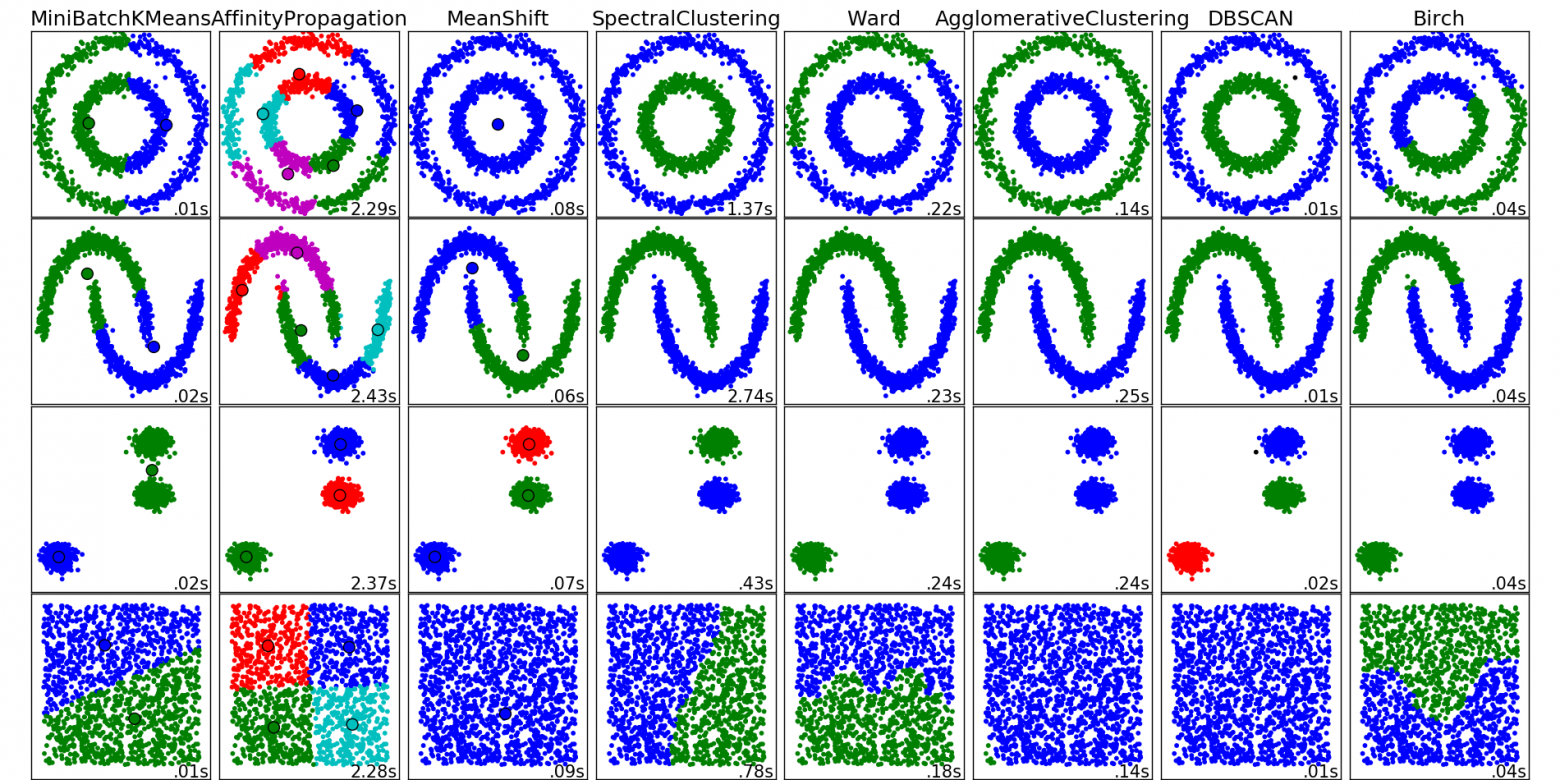

Изображение взято [отсюда](https://scikit-learn.org/stable/modules/clustering.html)

Посмотрим, как работает алгоритм ```DBSCAN``` на различных данных:

In [ ]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1, min_samples=10)
db.fit(X)
labels = db.labels_

print("Estimated number of clusters: %d" % np.unique(labels[ labels!=-1 ]).shape[0] )
print("Estimated number of noise points: %d" % list(labels).count(-1))

labels

In [ ]:
fig, ax = plt.subplots()
for lbl, color in zip(np.unique(labels), ['black', 'orange', 'green', 'blue', 'magenta']):
    idx = (labels == lbl)
    ax.scatter(X[idx,0], X[idx,1], color=color, marker='o', label=(f"Label={lbl}" if lbl!=-1 else 'Noise') )
    
plt.legend()
    
plt.show()

## Метрики качества в задачах кластеризации

В задачах кластеризации метрики качества помогают оценить, насколько хорошо выполнена группировка данных. Вот краткий обзор основных метрик:

1. **Метрика однородности** (```homogeneity_score```): Метрика однородности оценивает, состоит ли каждый кластер из объектов только одного класса. Значение 1 означает идеальную однородность, когда в каждом кластере объекты принадлежат к одному и тому же классу.
5. **Adjusted Rand Index (ARI)** (```adjusted_rand_score```): Значения от -1 до 1, где 1 означает полное совпадение. Оценивает сходство между двумя разбиениями данных.
6. **Взаимная информация** (```adjusted_mutual_info_score```): Измеряет количество информации, полученной об одном разбиении через другое. Лучше, когда выше.
2. **Силуэт** (```silhouette_score```): Значения близкие к +1 указывают на хорошую кластеризацию. Оценивает, насколько объекты близки к своему кластеру по сравнению с ближайшими кластерами.


Эти метрики помогают выбрать наилучший алгоритм кластеризации и настроить его параметры для конкретного набора данных.


In [ ]:
from sklearn import metrics

print(f"Homogeneity: {metrics.homogeneity_score(y, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y, labels):.3f}")
print(f"Adjusted Mutual Information: {metrics.adjusted_mutual_info_score(y, labels):.3f}")

print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

#### ⁉️ Задание

1. Для искуственного датасета подберите параметры алгоритма классификации ```DBSCAN``` для того, чтобы получилось два кластера. Посчитайте метрики.

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=500, factor=0.01, 
                    noise=0.2, random_state=0)

fig, ax = plt.subplots()

for label in [0,1]:
    idx = (y == label)
    ax.scatter(X[idx,0], X[idx,1], label=label )

plt.legend()
    
plt.show()

In [ ]:
# ваш код здесь



#### Практический пример

Пример применения кластеризации - визуализация геоданных, например, по медианному доходу домохозяйств в различных областях Калифорнии [из этой статьи на Kaggle](https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means/tutorial):
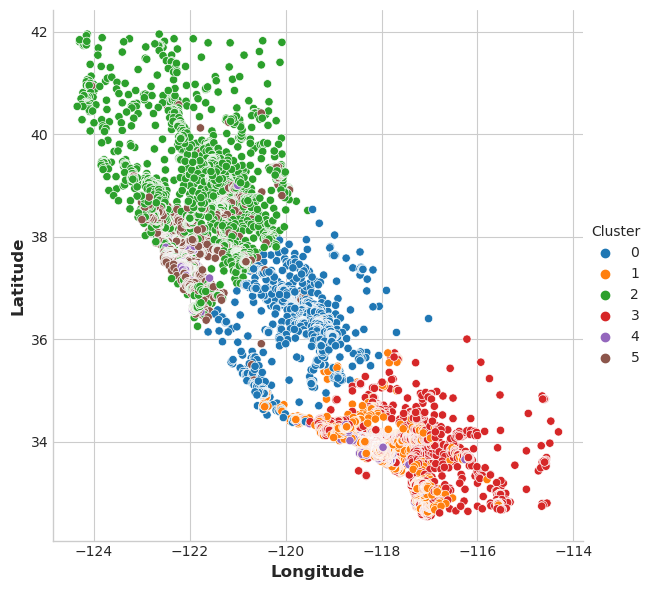

## Снижение размерности, метод PCA

***PCA*** - Principal Component Analysis или "Метод Главных Компонент" позволяет снижать размерность данных, используя данные ковариационной матрицы признаков. Матрица ковариации представляет собой симметричную матрицу, где на диагонали лежат дисперсии признаков, а вне диагонали — ковариации соответствующих пар признаков. 

Этот метод уменьшает размерность данных, выбирая новые признаки, которые максимизируют вариативность, не теряя при этом много информации. Это делается путем:

1. Стандартизации данных.
2. Вычисления ковариационной матрицы.
3. Нахождения собственных векторов и значений этой матрицы.
4. Выбора векторов с наибольшими собственными значениями как новых признаков.
5. Преобразования данных в новое пространство с меньшим количеством признаков.

Посмотрим на примере датасета "Ирисы Фишера".

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

_ = sns.pairplot(X,
             diag_kind='kde', plot_kws={'alpha': 0.2})

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print(pca.components_)

print("Из чего состоят компоненты:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))
plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=70)
plt.show()


Рассмотрим применение метода главных компонент для визуализации данных из набора изображений рукописных цифр.

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(12,10))

plt.title('Проектируем %d-мерные данные в 2D' % X.shape[1])

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=matplotlib.colormaps.get_cmap('nipy_spectral'))
plt.colorbar()
plt.show()

Полученная картинка позволяет увидеть зависимости между различными цифрами. Например, цифры 0 и 6 располагаются в соседних кластерах, что говорит об их схожем написании. Наиболее "разбросанный" (по другим кластерам) - это кластер, соответствующий цифре 8, что говорит о том, что она имеет много различных написаний, делающих её схожей со многими другими цифрами.

Посмотрим, как выглядят первые две главные компоненты.

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7,4))

im = pca.components_[0]
ax1.imshow(im.reshape((8, 8)), cmap='gray_r')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('First principal component')

im = pca.components_[1]
ax2.imshow(im.reshape((8, 8)), cmap='gray_r')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Second principal component')
plt.show()

### Сжатие данных

Другим применением PCA является снижение размерности данных для их сжатия. Рассмотрим, как влияет число отбираемых главных компонент (на которые осуществляется проекция) на качество восстановления исходного изображения.

In [ ]:
plt.figure(figsize=(4,2))
plt.imshow(X[15].reshape((8, 8)), cmap='gray_r')
plt.xticks([])
plt.yticks([])
plt.title('Source image')
plt.show()

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    components = 64-i
    pca = PCA(components).fit(X)
    im = pca.transform([ X[15] ])
    im = pca.inverse_transform(im)

    ax.imshow(im.reshape((8, 8)), cmap='gray_r')
    ax.text(0.95, 0.05, f'n = {format(components)}', ha='right',
            transform=ax.transAxes, color='red')
    ax.set_xticks([])
    ax.set_yticks([])

Как понять, какое число главных компонент достаточно оставить? Для этого может оказаться полезным следующий график, выражающий зависимость общей доли объясняемой дисперсии от числа главных компонент.

In [ ]:
pca = PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(20, c='b')
plt.axhline(0.9, c='r')
plt.show()

In [ ]:
pca = PCA(0.9).fit(X)
print('We need %d components to explain 90%% of variance' 
      % pca.n_components_)

## Алгоритм t-SNE

**t-SNE** - (t-Distributed Stochastic Neighbor Embedding) — это алгоритм машинного обучения без учителя, используемый для визуализации высокоразмерных данных путём их сокращения до двух или трёх измерений, что делает эти данные подходящими для графического представления. Он разработан так, чтобы группировать похожие данные вместе и отделять несхожие, что помогает визуально оценить структуру данных.

В отличие от других методов уменьшения размерности, таких как PCA (главные компоненты), t-SNE фокусируется на сохранении малых попарных расстояний или схожести между точками, что делает его особенно хорошим для изучения локальной структуры данных. Он превосходно подходит для визуализации кластеров или групп в данных, но может быть вычислительно затратным на больших наборах данных.

In [ ]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=matplotlib.colormaps.get_cmap('nipy_spectral'))
plt.colorbar()
plt.title('Digits. t-SNE projection')

#### ⁉️ Задание

Выполнить кластерный анализ для образцов из файла "voices.csv":
1. определить предположительное число кластеров (на всех признаках и на проекции в 2D);
2. определить, каким классификационным меткам соответствуют эти кластеры, визуализировать это с помощью PCA и t-SNE.

In [ ]:
# ваш код здесь



## Поиск статистических выбросов (outlier detection)

Такую задачу также называют задачей классификации в рамках одного класса.

Рассмотрим эту задачу на примере датасета "Девушки журнала Playboy":

In [ ]:
girls = pd.read_csv('data/girls.csv')
girls

In [ ]:
params = ['Bust', 'Waist', 'Hips', 'Height', 'Weight']
girls_params = girls[ params ]
sns.pairplot(girls_params, diag_kind='kde', plot_kws={'alpha': 0.2});

In [ ]:
# масштабируем данные
from sklearn.preprocessing import StandardScaler


girls_params = pd.DataFrame( StandardScaler().fit_transform(girls_params), columns=params)
sns.pairplot(girls_params, diag_kind='kde', plot_kws={'alpha': 0.2});

In [ ]:
from sklearn.svm import OneClassSVM
from scipy import stats

outlier_pct = 0.01

# обучаем модель
svm_clf = OneClassSVM(kernel="rbf")
svm_clf.fit(girls_params)

# получаем вектор расстояний
dist_to_border = svm_clf.decision_function(girls_params).ravel()
threshold = stats.scoreatpercentile(dist_to_border,
            100 * outlier_pct)
is_outlier = dist_to_border < threshold
is_outlier

In [ ]:
girls_num = girls_params.shape[0]

# для визуализации обучим ту же модель на данных, ужатых до 2D через PCA
X = PCA(n_components=2).fit_transform(girls_params)
svm_clf = OneClassSVM(kernel="rbf")
svm_clf.fit(X)

xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - outlier_pct) * girls_num)
n_outliers = int(outlier_pct * girls_num)

Z = svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Outlier detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
b = plt.scatter(X[is_outlier, 0], X[is_outlier, 1], c='black')
c = plt.scatter(X[is_outlier == 0, 0], X[is_outlier == 0, 1], c='white')
plt.axis('tight')
plt.legend([a.collections[0], b, c],
           ['learned decision function', 'outliers', 'inliers'],
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlim((-7, 7))
plt.ylim((-7, 7));

In [ ]:
girls.iloc[ is_outlier ]

Посмотреть, какие еще алгоритмы предлагает sklearn, можно по [ссылке](https://scikit-learn.org/stable/modules/outlier_detection.html).

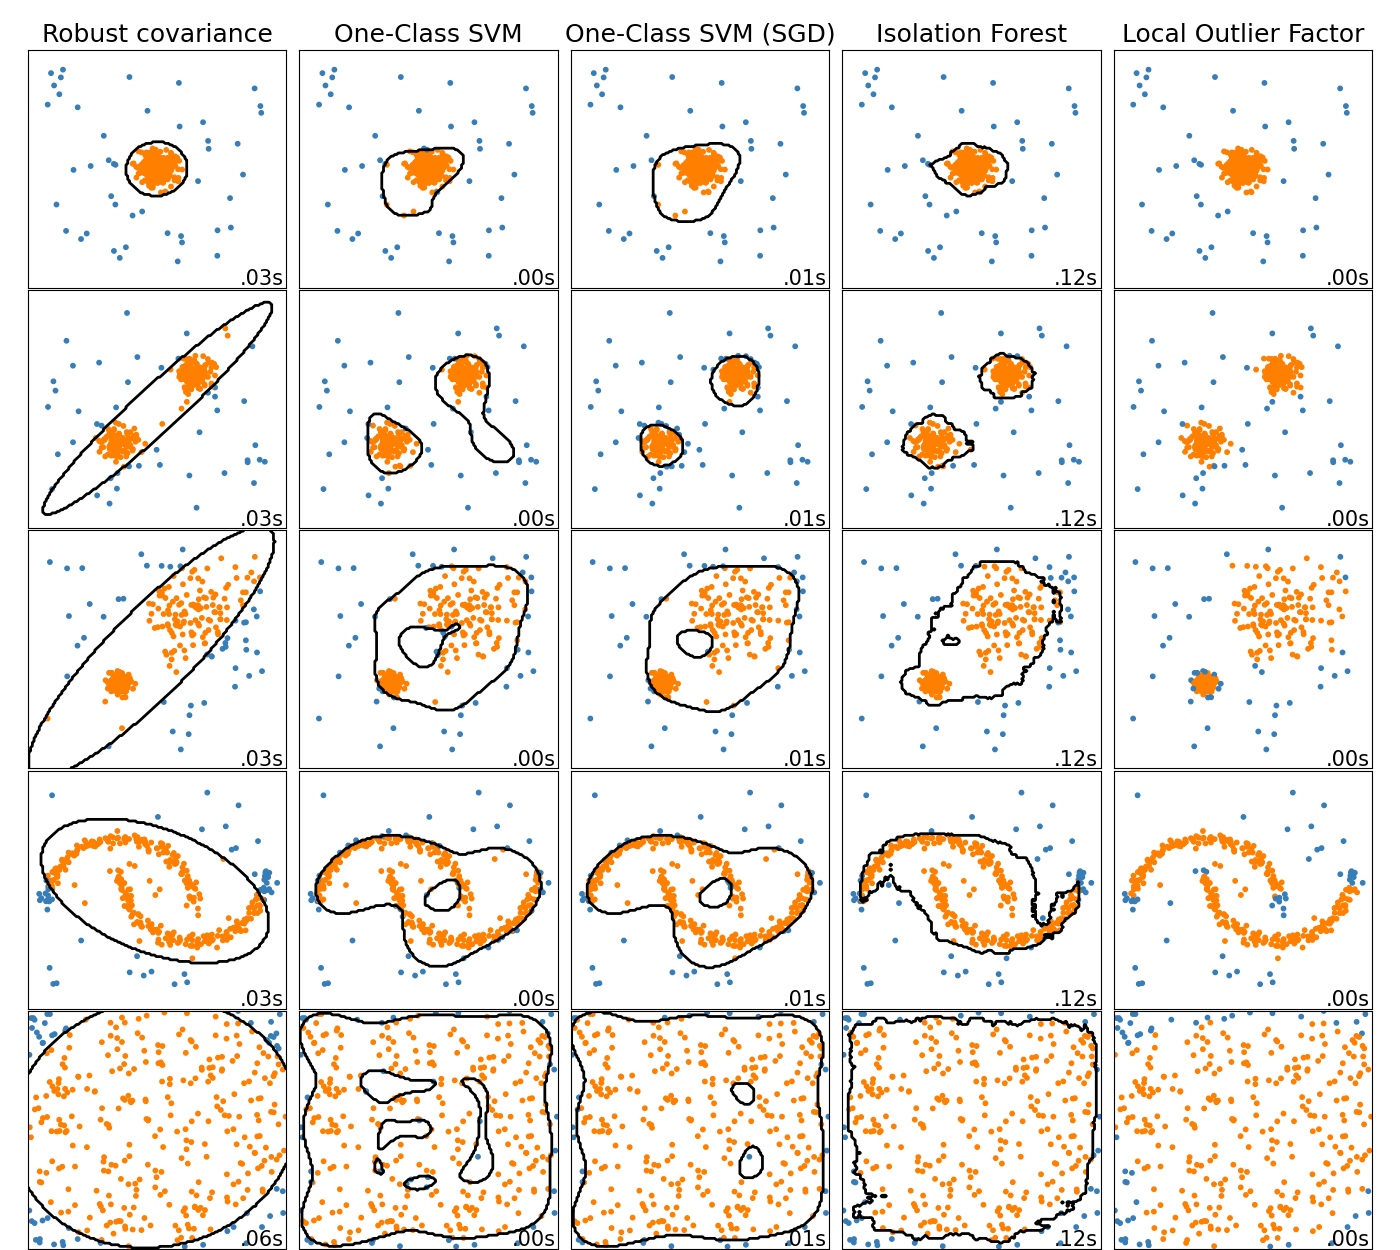

#### ⁉️ Задание

Выполните анализ выбросов для датасета "credit_scoring.csv".

In [ ]:
# ваш код здесь



## Классификация объектов по бесконечному количеству классов методом поиска ближайших соседей

Задача классификации по бесконечному количеству классов возникает в следующих случаях:
- подбор похожих объектов по образцу:
    - рекомендательные системы
    - поиск фото по текстовому описанию и по фото
    - поиск и идентификация аномалий на рентгеновских снимках/МРТ/КТ
- идентификация объектов по различным паттернам:
    - поиск людей по фото, деталям фигуры, походки, прочее
    - поиск музыки по фрагментам
    - "антиплагиат"
- обнаружение новых трендов и тем для обсуждения в социальных медиа и в интернете

Обычно эта задача решается при помощи алгоритма kNN - поиска $k$ ближайших соседей. Некоторые относят данный алгоритм в раздел "Обучение с учителем", но на самом деле, при каждом прогнозе данный алгоритм использует всю обучающую выборку. И поэтому вообще сомнительно утверждать то, что это имеет отношение к машинному обучению. Скорее всего, это дальнейшее развитие темы кластеризации данных.

Для алгоритма k-ближайших соседей (kNN) важен следующий препроцессинг данных:

1. **Обработка пропущенных значений**: Заполните или удалите пропущенные значения, чтобы алгоритм мог корректно вычислять расстояния.
2. **Преобразование категориальных данных**: Конвертируйте категориальные признаки в числовые для возможности вычисления расстояний.
3. **Удаление выбросов**: Избавьтесь от аномальных значений, которые могут исказить результаты.
3. **Масштабирование признаков**: Унифицируйте масштаб всех признаков, чтобы один не доминировал над другими. Можно использовать ```MinMaxScaler()```, ```StandardScaler()``` или ```normalization()```.
5. **Уменьшение размерности**: Сократите количество признаков, чтобы избежать проблемы "проклятия размерности".

Также на качество работы kNN влияет __выбор метрики расстояния__ (Евклидово, Косинусное, Хэмминга, пр.). Вот наиболее часто используемые метрики:

1. **Евклидово расстояние**: Идеально подходит для непрерывных числовых данных с одинаковым масштабом. 

2. **Расстояние Хэмминга**: Расстояние Хэмминга подсчитывает число позиций, в которых соответствующие символы двух строк различны. Хорошо работает с категориальными или бинарными данными. Пример: поиск изображений по хэш-значениям.

3. **Косинусное сходство**: Косинусное сходство измеряет угол между двумя векторами в многомерном пространстве, что позволяет судить о схожести по направлению, а не по магнитуде векторов. Пример: анализ текстов, где данные представлены в виде векторов слов или фраз.


Рассмотрим на примере датасета "Рукописные цифры".

In [ ]:
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

digits = datasets.load_digits()
X, y = digits.data, digits.target

X = MinMaxScaler().fit_transform(X)

ix_random_image = 15

plt.figure(figsize=(4,2))
plt.imshow(X[ix_random_image].reshape((8, 8)), cmap='gray_r')
plt.xticks([])
plt.yticks([])
plt.title('Source image')
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=10,
                             algorithm='brute',
                             metric='euclidean')

neighbors.fit(X)

distances, indices = neighbors.kneighbors(X[ [ix_random_image] ])
print(distances)
print(indices)

In [ ]:
fig = plt.figure(figsize=(20, 2))
for i, (idx, digit) in enumerate(zip(indices[0], X[ indices[0] ])):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(digit.reshape((8, 8)), cmap='gray_r')
    ax.set_title(f"idx={idx}")
    
plt.show()

Классификатор ```KNeighborsClassifier``` может предсказывать и класс, и вероятность отнесения к классу.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=20231110,
                                                   stratify = y)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


model = KNeighborsClassifier(n_neighbors=10,
                             algorithm='brute',
                             metric='euclidean')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print(f"Accuracy score on test set: {accuracy_score(y_test, y_pred)}")
print(f"ROC-AUC score on test set: {roc_auc_score(y_test, y_pred_proba, multi_class='ovr')}")

#### ⁉️ Задание

Преобразуйте данные в 2D методами главных компонент и t-SNE. Выполните кросс-валидацию классификатора ```KNeighborsClassifier``` на этих множествах для метрик ```accuracy_score``` и ```roc_auc```. Сделайте выводы.

In [ ]:
# ваш код здесь



## Использованные материалы

- [Scikit-learn Clustering (документация sklearn)](https://scikit-learn.org/stable/modules/clustering.html)
- [Clustering With K-Means (статья на Kaggle)](https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means/tutorial)
- [Как применять метод PCA для уменьшения размерности данных](https://habr.com/ru/companies/otus/articles/769274/)
- [Principal Component Analysis(Feature Extraction Technique)](https://medium.com/@mayureshrpalav/principal-component-analysis-feature-extraction-technique-3f480d7b9697)
- [10 Clustering Algorithms With Python](https://machinelearningmastery.com/clustering-algorithms-with-python/)
- [Необычные модели Playboy, или про обнаружение выбросов в данных c помощью Scikit-learn](https://habr.com/ru/articles/251225/)